In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INPUT_PATH = "data/train/input_2023_w01.csv"
OUTPUT_PATH = "data/train/output_2023_w01.csv"
SUPP_PATH = "data/supplementary_data.csv"

inp = pd.read_csv(INPUT_PATH)
out = pd.read_csv(OUTPUT_PATH)
supp = pd.read_csv(SUPP_PATH)


/var/folders/xm/lcfnqfw931d_v613yc9jpq480000gn/T/ipykernel_15384/1697144655.py:11: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supp = pd.read_csv(SUPP_PATH)


In [13]:
role_cols = [
    "game_id", "play_id", "nfl_id",
    "player_name", "player_side", "player_role",
    "ball_land_x", "ball_land_y"
]

role_map = inp[role_cols].drop_duplicates(
    subset=["game_id","play_id","nfl_id"]
)

df = out.merge(
    role_map,
    on=["game_id","play_id","nfl_id"],
    how="left"
)

meta_cols = [
    "game_id","play_id",
    "pass_result","route_of_targeted_receiver"
]

play_meta = supp[meta_cols].drop_duplicates(["game_id","play_id"])

df = df.merge(
    supp[meta_cols].drop_duplicates(subset=["game_id","play_id"]),
    on=["game_id","play_id"],
    how="left"
)


In [3]:
def find_candidate_plays(df, min_defenders=2):
    plays = []
    for (gid,pid), g in df.groupby(["game_id","play_id"]):
        if (g["player_role"]=="Targeted Receiver").any():
            ndef = (g["player_role"]=="Defensive Coverage").sum()
            if ndef >= min_defenders:
                plays.append((gid,pid,ndef))
    return plays

GAME_ID, PLAY_ID, _ = find_candidate_plays(df)[0]
print("Using play:", GAME_ID, PLAY_ID)


Using play: 2023090700 101


In [4]:
def compute_catch_window(df, game_id, play_id):
    g = df[(df.game_id==game_id)&(df.play_id==play_id)].copy()

    # landing point (fixed)
    land_x = g["ball_land_x"].dropna().iloc[0]
    land_y = g["ball_land_y"].dropna().iloc[0]

    # targeted receiver
    tr_all = g[g["player_role"]=="Targeted Receiver"]
    tr_id = tr_all.groupby("nfl_id")["frame_id"].count().idxmax()
    tr = g[g["nfl_id"]==tr_id].sort_values("frame_id").copy()

    tr["rec_dist"] = np.hypot(tr["x"]-land_x, tr["y"]-land_y)

    # defenders
    defs = g[g["player_role"]=="Defensive Coverage"].copy()

    rows = []
    for fid, frame in defs.groupby("frame_id"):
        frame = frame.copy()
        frame["def_dist"] = np.hypot(frame["x"]-land_x, frame["y"]-land_y)
        best = frame.sort_values("def_dist").iloc[0]

        rows.append((
            fid,
            best["def_dist"],
            best["nfl_id"],
            best["player_name"]
        ))

    closest = pd.DataFrame(
        rows,
        columns=["frame_id","min_def_dist","closest_def_id","closest_def_name"]
    )

    series = tr[["frame_id","x","y","player_name","rec_dist"]].merge(
        closest, on="frame_id", how="left"
    )

    # window margin (positive = receiver closer)
    series["dist_margin"] = series["min_def_dist"] - series["rec_dist"]

    # window opening moment
    open_frames = series[series["dist_margin"] >= 0]
    t_open = int(open_frames.iloc[0]["frame_id"]) if len(open_frames) else None

    meta = {
        "game_id": game_id,
        "play_id": play_id,
        "target_name": tr["player_name"].iloc[0],
        "route": g["route_of_targeted_receiver"].iloc[0],
        "pass_result": g["pass_result"].iloc[0],
        "landing_x": land_x,
        "landing_y": land_y,
        "t_open": t_open
    }

    return series, g, meta


In [5]:
series, gplay, meta = compute_catch_window(df, GAME_ID, PLAY_ID)
meta


{'game_id': 2023090700,
 'play_id': 101,
 'target_name': 'Josh Reynolds',
 'route': 'CORNER',
 'pass_result': 'I',
 'landing_x': 63.2599983215332,
 'landing_y': -0.219999998807907,
 't_open': 1}

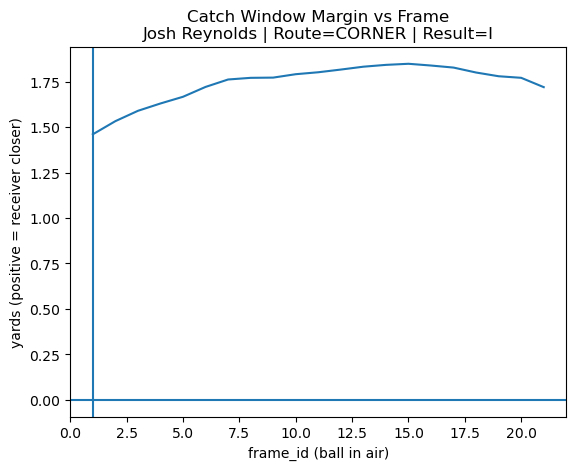

In [6]:
plt.figure()
plt.plot(series["frame_id"], series["dist_margin"])
plt.axhline(0)
if meta["t_open"] is not None:
    plt.axvline(meta["t_open"])
plt.title(
    f"Catch Window Margin vs Frame\n"
    f"{meta['target_name']} | Route={meta['route']} | Result={meta['pass_result']}"
)
plt.xlabel("frame_id (ball in air)")
plt.ylabel("yards (positive = receiver closer)")
plt.show()


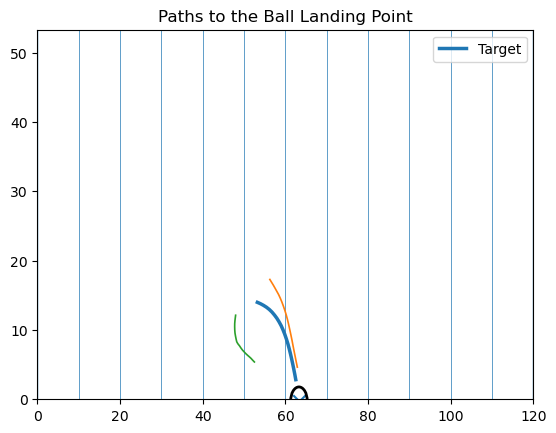

In [7]:
def draw_field(ax):
    ax.set_xlim(0,120)
    ax.set_ylim(0,53.3)
    for x in range(10,111,10):
        ax.axvline(x, linewidth=0.5)
    ax.axvline(0, linewidth=1)
    ax.axvline(120, linewidth=1)

def plot_paths(gplay, meta, radius=2.0):
    fig = plt.figure()
    ax = plt.gca()
    draw_field(ax)

    tr = gplay[gplay["player_role"]=="Targeted Receiver"].sort_values("frame_id")
    ax.plot(tr["x"], tr["y"], linewidth=2.5, label="Target")

    defs = gplay[gplay["player_role"]=="Defensive Coverage"]
    for _, d in defs.groupby("nfl_id"):
        d = d.sort_values("frame_id")
        ax.plot(d["x"], d["y"], linewidth=1.2)

    ax.scatter(meta["landing_x"], meta["landing_y"], marker="x", s=80)
    ax.add_patch(
        plt.Circle(
            (meta["landing_x"], meta["landing_y"]),
            radius,
            fill=False,
            linewidth=2
        )
    )

    ax.set_title("Paths to the Ball Landing Point")
    ax.legend()
    plt.show()
    return fig

fig = plot_paths(gplay, meta)


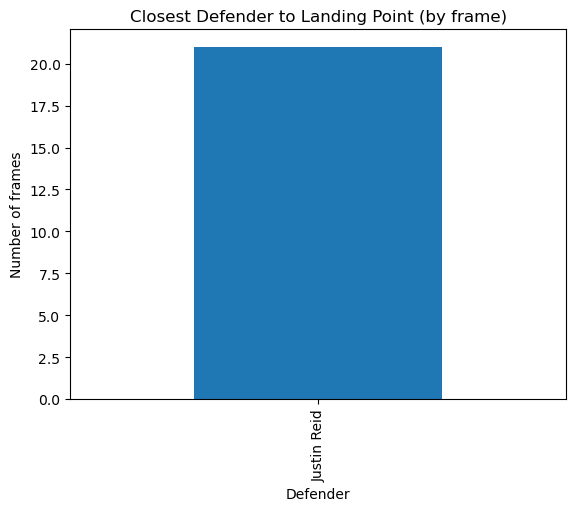

In [8]:
plt.figure()
series["closest_def_name"].value_counts().plot(kind="bar")
plt.title("Closest Defender to Landing Point (by frame)")
plt.xlabel("Defender")
plt.ylabel("Number of frames")
plt.show()


In [9]:
fig.set_size_inches(5.6, 2.8)
fig.savefig("catch_window_card.png", dpi=100, bbox_inches="tight")


In [ ]:

df["is_tr"] = (df["player_role"] == "Targeted Receiver")
df["is_def"] = (df["player_role"] == "Defensive Coverage")


tr_counts = (
    df[df["is_tr"]]
    .groupby(["game_id","play_id","nfl_id"])["frame_id"]
    .count()
    .reset_index(name="n_frames")
)

tr_id_map = (
    tr_counts.sort_values(["game_id","play_id","n_frames"], ascending=[True,True,False])
    .drop_duplicates(["game_id","play_id"])
    .rename(columns={"nfl_id":"tr_nfl_id"})
    [["game_id","play_id","tr_nfl_id"]]
)

tr_id_map.head()


,game_id,play_id,tr_nfl_id
0,2023090700,101,44930
1,2023090700,194,41325
2,2023090700,219,53591
3,2023090700,361,38696
4,2023090700,436,53541


In [ ]:

df2 = df.merge(tr_id_map, on=["game_id","play_id"], how="inner")

# receiver
rec = df2[df2["nfl_id"] == df2["tr_nfl_id"]].copy()

# landing point
rec["rec_dist"] = np.hypot(rec["x"] - rec["ball_land_x"], rec["y"] - rec["ball_land_y"])

rec_frame = rec[["game_id","play_id","frame_id","tr_nfl_id","player_name","rec_dist","ball_land_x","ball_land_y"]].copy()
rec_frame = rec_frame.rename(columns={"player_name":"target_name"})

# defenders
defs = df2[df2["is_def"]].copy()
defs["def_dist"] = np.hypot(defs["x"] - defs["ball_land_x"], defs["y"] - defs["ball_land_y"])

defs_min = defs.sort_values(["game_id","play_id","frame_id","def_dist"]).drop_duplicates(
    ["game_id","play_id","frame_id"]
)
defs_min = defs_min.rename(columns={"nfl_id":"closest_def_id", "player_name":"closest_def_name"})
defs_min = defs_min[["game_id","play_id","frame_id","def_dist","closest_def_id","closest_def_name"]]
defs_min = defs_min.rename(columns={"def_dist":"min_def_dist"})

frame_series = rec_frame.merge(defs_min, on=["game_id","play_id","frame_id"], how="left")

frame_series["dist_margin"] = frame_series["min_def_dist"] - frame_series["rec_dist"]
frame_series["window_open"] = frame_series["dist_margin"] >= 0

frame_series.head()


,game_id,play_id,frame_id,tr_nfl_id,target_name,rec_dist,ball_land_x,ball_land_y,min_def_dist,closest_def_id,closest_def_name,dist_margin,window_open
0,2023090700,101,1,44930,Josh Reynolds,17.402401,63.259998,-0.22,18.862968,46137.0,Justin Reid,1.460567,True
1,2023090700,101,2,44930,Josh Reynolds,16.807438,63.259998,-0.22,18.340307,46137.0,Justin Reid,1.532870,True
2,2023090700,101,3,44930,Josh Reynolds,16.205282,63.259998,-0.22,17.795010,46137.0,Justin Reid,1.589728,True
3,2023090700,101,4,44930,Josh Reynolds,15.607773,63.259998,-0.22,17.237923,46137.0,Justin Reid,1.630150,True
4,2023090700,101,5,44930,Josh Reynolds,14.995258,63.259998,-0.22,16.662259,46137.0,Justin Reid,1.667001,True


In [ ]:
# ball-in-air 
play_frames = frame_series.groupby(["game_id","play_id"])["frame_id"].count().reset_index(name="n_frames_air")

# CWD：window_open 
cwd = frame_series.groupby(["game_id","play_id"])["window_open"].sum().reset_index(name="CWD")

# t_open：第一次 window_open 的 frame
topen = (
    frame_series[frame_series["window_open"]]
    .groupby(["game_id","play_id"])["frame_id"]
    .min()
    .reset_index(name="t_open")
)

play_table = play_frames.merge(cwd, on=["game_id","play_id"], how="left").merge(topen, on=["game_id","play_id"], how="left")
play_table["CWD"] = play_table["CWD"].fillna(0).astype(int)
play_table["CWD_pct"] = play_table["CWD"] / play_table["n_frames_air"]

who = frame_series.sort_values(["game_id","play_id","frame_id"]).drop_duplicates(["game_id","play_id"])
who = who[["game_id","play_id","tr_nfl_id","target_name","closest_def_id","closest_def_name","ball_land_x","ball_land_y"]]

play_table = play_table.merge(who, on=["game_id","play_id"], how="left")

play_table = play_table.merge(play_meta, on=["game_id","play_id"], how="left")

play_table.head(10)


,game_id,play_id,n_frames_air,CWD,t_open,CWD_pct,tr_nfl_id,target_name,closest_def_id,closest_def_name,ball_land_x,ball_land_y,pass_result,route_of_targeted_receiver
0,2023090700,101,21,21,1.0,1.000000,44930,Josh Reynolds,46137.0,Justin Reid,63.259998,-0.220000,I,CORNER
1,2023090700,194,9,8,1.0,0.888889,41325,Jerick McKinnon,54653.0,Malcolm Rodriguez,84.940002,21.750000,C,ANGLE
2,2023090700,219,8,8,1.0,1.000000,53591,Noah Gray,53953.0,Jerry Jacobs,75.849998,11.490000,C,HITCH
3,2023090700,361,16,16,1.0,1.000000,38696,Marvin Jones,46137.0,Justin Reid,26.100000,49.180000,C,HITCH
4,2023090700,436,7,7,1.0,1.000000,53541,Amon-Ra St. Brown,46137.0,Justin Reid,34.889999,34.820000,C,SLANT
5,2023090700,461,10,7,4.0,0.700000,44930,Josh Reynolds,46137.0,Justin Reid,55.910000,18.830000,C,POST
6,2023090700,530,8,8,1.0,1.000000,53541,Amon-Ra St. Brown,54568.0,Leo Chenal,88.690002,15.130000,C,OUT
7,2023090700,621,7,7,1.0,1.000000,53541,Amon-Ra St. Brown,47882.0,Mike Edwards,102.919998,18.270000,C,CROSS
8,2023090700,713,8,7,1.0,0.875000,53591,Noah Gray,44888.0,Alex Anzalone,79.910004,8.970000,I,OUT
9,2023090700,736,15,5,11.0,0.333333,46213,Justin Watson,55910.0,Brian Branch,68.470001,40.450001,C,CORNER


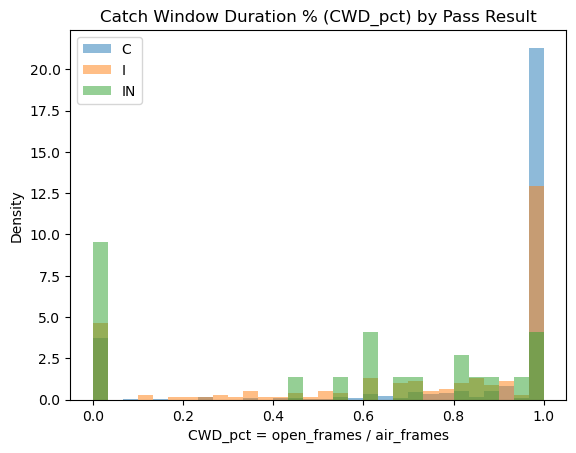

In [ ]:
keep = play_table[play_table["pass_result"].isin(["C","I","IN"])].copy()

plt.figure()
for r in ["C","I","IN"]:
    vals = keep.loc[keep["pass_result"]==r, "CWD_pct"].dropna()
    plt.hist(vals, bins=30, alpha=0.5, density=True, label=r)

plt.title("Catch Window Duration % (CWD_pct) by Pass Result")
plt.xlabel("CWD_pct = open_frames / air_frames")
plt.ylabel("Density")
plt.legend()
plt.show()


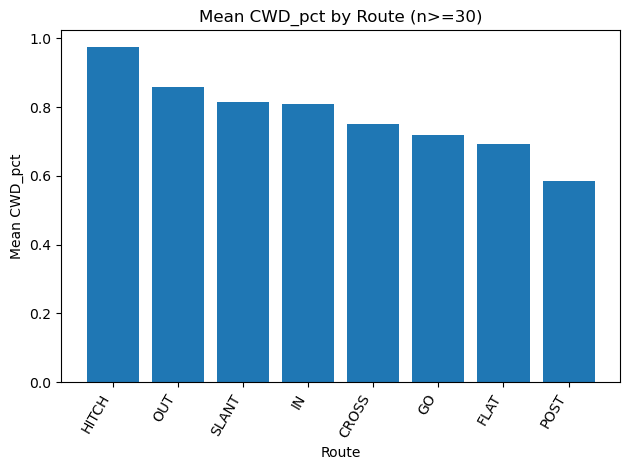

In [ ]:
route_summary = (
    keep.groupby("route_of_targeted_receiver")["CWD_pct"]
    .agg(["count","mean","median"])
    .sort_values("count", ascending=False)
)

min_n = 30
rs = route_summary[route_summary["count"] >= min_n].sort_values("mean", ascending=False).head(15)

plt.figure()
plt.bar(rs.index, rs["mean"])
plt.xticks(rotation=60, ha="right")
plt.title(f"Mean CWD_pct by Route (n>={min_n})")
plt.xlabel("Route")
plt.ylabel("Mean CWD_pct")
plt.tight_layout()
plt.show()


In [17]:
# frame_series columns needed:
# ["game_id","play_id","frame_id","rec_dist","min_def_dist","dist_margin"]
# play_table columns needed:
# ["game_id","play_id","pass_result","route_of_targeted_receiver","CWD_pct", ...]

# 1) take the last frame_id for each play
last_frames = (
    frame_series.groupby(["game_id","play_id"])["frame_id"]
    .max()
    .reset_index(name="last_frame_id")
)

# 2) pull the rows corresponding to each play's last frame
final_rows = frame_series.merge(
    last_frames,
    on=["game_id","play_id"],
    how="inner"
)
final_rows = final_rows[final_rows["frame_id"] == final_rows["last_frame_id"]].copy()

# 3) rename dist_margin to final_margin for clarity
final_rows = final_rows.rename(columns={"dist_margin":"final_margin"})

# 4) attach labels (pass_result, route, etc.)
final_table = final_rows.merge(
    play_table[["game_id","play_id","pass_result","route_of_targeted_receiver","CWD_pct"]],
    on=["game_id","play_id"],
    how="left"
)

# keep only major outcomes
final_table = final_table[final_table["pass_result"].isin(["C","I","IN"])].copy()

final_table[["game_id","play_id","pass_result","final_margin","CWD_pct"]].head()


,game_id,play_id,pass_result,final_margin,CWD_pct
0,2023090700,101,I,1.719960,1.000000
1,2023090700,194,C,-0.458191,0.888889
2,2023090700,219,C,2.898553,1.000000
3,2023090700,361,C,1.426343,1.000000
4,2023090700,436,C,2.523245,1.000000


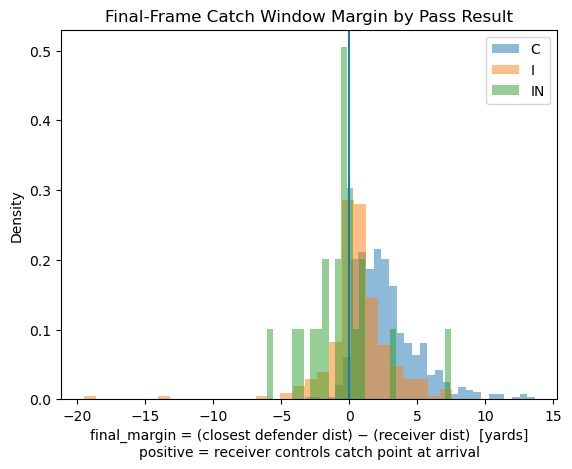

In [18]:
plt.figure()
for r in ["C","I","IN"]:
    vals = final_table.loc[final_table["pass_result"] == r, "final_margin"].dropna()
    plt.hist(vals, bins=30, alpha=0.5, density=True, label=r)

plt.axvline(0)
plt.title("Final-Frame Catch Window Margin by Pass Result")
plt.xlabel("final_margin = (closest defender dist) − (receiver dist)  [yards]\npositive = receiver controls catch point at arrival")
plt.ylabel("Density")
plt.legend()
plt.show()


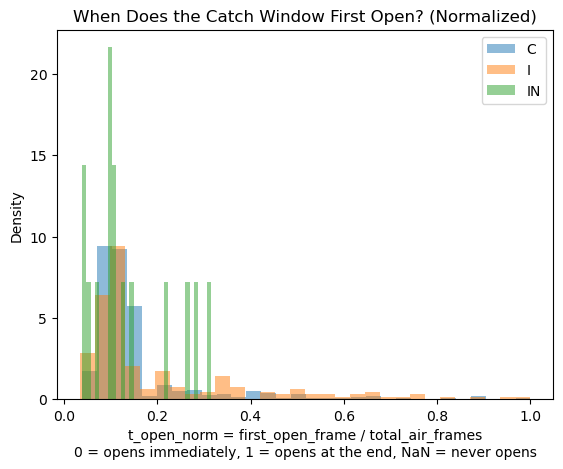

pass_result
C     0.124334
I     0.153846
IN    0.318182
Name: pct_never_open, dtype: float64


In [19]:
tmp = play_table[play_table["pass_result"].isin(["C","I","IN"])].copy()

# normalize opening time by flight length so plays of different lengths compare fairly
tmp["t_open_norm"] = tmp["t_open"] / tmp["n_frames_air"]

plt.figure()
for r in ["C","I","IN"]:
    vals = tmp.loc[tmp["pass_result"] == r, "t_open_norm"].dropna()
    plt.hist(vals, bins=30, alpha=0.5, density=True, label=r)

plt.title("When Does the Catch Window First Open? (Normalized)")
plt.xlabel("t_open_norm = first_open_frame / total_air_frames\n0 = opens immediately, 1 = opens at the end, NaN = never opens")
plt.ylabel("Density")
plt.legend()
plt.show()

# Also report how often the window never opens, by result
never_open = tmp["t_open"].isna()
print(tmp.groupby("pass_result")[never_open.name].apply(lambda x: (tmp.loc[x.index, "t_open"].isna()).mean()).rename("pct_never_open"))
